In [1]:
#! shred -u setup_google_colab.py
#! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
# setup_google_colab.setup_week1()
# setup_google_colab.setup_week2()
# setup_google_colab.setup_week3()
#setup_google_colab.setup_week4()
# setup_google_colab.setup_week5()
# setup_google_colab.setup_week6()

# If you're using the old version of the course (check a path of notebook on Coursera, you'll see v1 or v2),
# use setup_week2_old().

In [2]:
import sys
import os
sys.path.append("..")

In [3]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

import matplotlib.pyplot as plt

tf.test.gpu_device_name()

print(tf.__version__)



2.4.1


In [4]:
from tensorflow.keras.utils import Sequence

from data_loader import load_batch

class DataGenerator(Sequence):

  def __init__(self, data, base_dir, down_scale=2, batch_size=32, noisy=False, noise_factor=0.5, shuffle=True):
  
    self.data = data
    self.data_noisy = None
    self.index = [i for i in range(self.data.shape[0])]
    self.base_dir = base_dir
    
    self.batch_size = batch_size
    self.noisy = noisy
    self.noise_factor = noise_factor
    self.shuffle = shuffle
    self.on_epoch_end()
    print(self.data.shape)
    print(int(self.data.shape[0] / self.batch_size))

  def __len__(self):
    return int(self.data.shape[0] / self.batch_size)

  def __getitem__(self, index):
    aug = np.zeros((self.batch_size,5))
    batch = np.hstack((self.data[index:index+self.batch_size],aug))
    img, accels, sds, tf, c_a = load_batch(batch,self.base_dir,down_scale=2)
    img = np.expand_dims(img, axis=-1)
    accels = np.expand_dims(accels[:,:,:,2], axis=-1)
    tf = np.expand_dims(tf,axis=-1)
    accels = np.multiply(accels,tf)
    return [img, c_a, tf], accels

  def on_epoch_end(self):
    np.random.shuffle(self.index)

In [5]:
stamps = np.load("/media/ros/de64b3cc-d3b4-44e1-b807-300d3d8adb21/ss_terrain_nav/data/dirs_and_files.npy",allow_pickle=True)
length = len(stamps[0])+len(stamps[1])+len(stamps[2])+len(stamps[3])+len(stamps[4])
print(len(stamps[0]))
print(len(stamps[1]))
print(len(stamps[2]))
print(len(stamps[3]))
print(len(stamps[4]))
print(length)
stamps = stamps.flatten()
length = len(stamps[0])
#length = 100
stamps = [stamps[0]+stamps[1]+stamps[2]+stamps[3]+stamps[4]]
print(length)
stamps = np.squeeze(np.array(stamps))
train = stamps[length:]
#train = stamps[:length]
test = stamps[:length]
print(len(train))
print(len(test))
print(len(stamps))

15064
16180
15318
15580
15437
77579
15064
62515
15064
77579


<ipython-input-5-a21ed046d350>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stamps = np.squeeze(np.array(stamps))


In [6]:
train_gen = DataGenerator(train, "/media/ros/de64b3cc-d3b4-44e1-b807-300d3d8adb21/ss_terrain_nav/data/", noisy=True)
test_gen = DataGenerator(test, "/media/ros/de64b3cc-d3b4-44e1-b807-300d3d8adb21/ss_terrain_nav/data/", noisy=True)

(62515, 2)
1953
(15064, 2)
470


In [ ]:
# UNQ_C1
# GRADED FUNCTION: conv_block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(n_filters, # Number of filters
                  (3,3),   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  (3,3),   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        conv = Dropout(dropout_prob)(conv)
         ### END CODE HERE
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = MaxPooling2D()(conv)
        ### END CODE HERE
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    ### START CODE HERE
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 (3,3),     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,   # Number of filters
                 (3,3),     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    return conv

In [7]:
def convolutional_model(img_shape, filters=[32,64,128,64], kernel_size=[9,9,9,9], 
                           pool_sizes=[2,2,2,2], pool_strides=[2,2,2,2]):
    """PCA's deeper brother. See instructions above. Use `code_size` in layer definitions."""
    H,W,C = img_shape
    
    conv = tfl.Input(shape=img_shape)
    P = img
    
    binary_tf = tfl.Input(shape=img_shape)
    
    accel = tfl.Input(shape=(6,))
    
    denom = np.prod(pool_strides)
    
    end_size_0 = int(H / denom)
    end_size_1 = int(W / denom)
    middle_size = end_size_0 * end_size_1 * filters[-1]
    
    for i in range(len(filters)):
        Z = tfl.Conv2D(filters[i],kernel_size[i],padding='same')(P)
        A = tfl.ReLU()(Z)
        P = tfl.MaxPool2D(pool_size=(pool_sizes[i],pool_sizes[i]),
                        strides=(pool_strides[i],pool_strides[i]),padding='same')(A)
        
    F = tfl.Flatten()(P)
    
    cat = tfl.concatenate([F,accel])
    
    D = tfl.Dense(middle_size,activation='relu')(cat)
    
    D = tfl.Dense(middle_size,activation='relu')(D)
    
    Z = tfl.Reshape((end_size_0,end_size_1,filters[-1]))(D)
    
    for i in range(len(filters)-2,-1,-1):
        Z = tfl.Conv2DTranspose(filters=filters[i], kernel_size=(kernel_size[i],kernel_size[i]),
                             strides=pool_strides[i], padding='same', activation='relu')(Z)
        
    output = tfl.Conv2DTranspose(filters=1, kernel_size=(kernel_size[0],kernel_size[0]),
                               strides=pool_strides[0],activation=None, padding='same')(Z)
    
    #output = tfl.Multiply()([binary_tf,Z])
    
    model = tf.keras.Model(inputs=[img,accel,binary_tf],outputs=output)
    return model

In [8]:
conv_model = convolutional_model((int(480/2), int(640/2), 1))
conv_model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mse'])
conv_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 320, 32) 2624        input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 240, 320, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 120, 160, 32) 0           re_lu[0][0]                      
______________________________________________________________________________________________

In [9]:
# we will save model checkpoints here to continue training in case of kernel death
model_filename = 'autoencoder.{0:03d}.hdf5'
last_finished_epoch = None
checkpoint_filepath = "/media/ros/de64b3cc-d3b4-44e1-b807-300d3d8adb21/ss_terrain_nav/data/saved/{epoch:02d}-{val_loss:.2f}"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                              monitor='val_loss',
                                                              mode='min',
                                                              verbose=1)

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 4
# autoencoder = load_model(model_filename.format(last_finished_epoch))
# encoder = autoencoder.layers[1]
# decoder = autoencoder.layers[2]

In [10]:
history = conv_model.fit_generator(generator=train_gen,
                                    validation_data=test_gen,
                                    validation_steps=32,
                                    steps_per_epoch=64*4,
                                    callbacks=model_checkpoint_callback,
                                    epochs=50)

/home/ros/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
256/256 [==============================] - 1624s 3s/step - loss: 2783.7272 - mse: 2783.7275 - val_loss: 2325.5808 - val_mse: 2325.5806

Epoch 00001: saving model to /media/ros/de64b3cc-d3b4-44e1-b807-300d3d8adb21/ss_terrain_nav/data/saved/01-2325.58
INFO:tensorflow:Assets written to: /media/ros/de64b3cc-d3b4-44e1-b807-300d3d8adb21/ss_terrain_nav/data/saved/01-2325.58/assets
Epoch 2/50
256/256 [==============================] - 698s 3s/step - loss: 2402.4607 - mse: 2402.4605 - val_loss: 1789.8680 - val_mse: 1789.8679

Epoch 00002: saving model to /media/ros/de64b3cc-d3b4-44e1-b807-300d3d8adb21/ss_terrain_nav/data/saved/02-1789.87
INFO:tensorflow:Assets written to: /media/ros/de64b3cc-d3b4-44e1-b807-300d3d8adb21/ss_terrain_nav/data/saved/02-1789.87/assets
Epoch 3/50
256/256 [==============================] - 686s 3s/step - loss: 1919.6645 - mse: 1919.6651 - val_loss: 1814.1143 - val_mse: 1814.1140

Epoch 00003: saving model to /media/ros/de64b3cc-d3b4-44e1-b807-300d3d8adb21/ss

256/256 [==============================] - 670s 3s/step - loss: 2755.0313 - mse: 2755.0310 - val_loss: 2489.2224 - val_mse: 2489.2222

Epoch 00043: saving model to /media/ros/de64b3cc-d3b4-44e1-b807-300d3d8adb21/ss_terrain_nav/data/saved/43-2489.22
INFO:tensorflow:Assets written to: /media/ros/de64b3cc-d3b4-44e1-b807-300d3d8adb21/ss_terrain_nav/data/saved/43-2489.22/assets
Epoch 44/50
256/256 [==============================] - 682s 3s/step - loss: 2744.4470 - mse: 2744.4472 - val_loss: 2473.3362 - val_mse: 2473.3367

Epoch 00044: saving model to /media/ros/de64b3cc-d3b4-44e1-b807-300d3d8adb21/ss_terrain_nav/data/saved/44-2473.34
INFO:tensorflow:Assets written to: /media/ros/de64b3cc-d3b4-44e1-b807-300d3d8adb21/ss_terrain_nav/data/saved/44-2473.34/assets
Epoch 45/50
256/256 [==============================] - 680s 3s/step - loss: 2730.6551 - mse: 2730.6546 - val_loss: 2458.2209 - val_mse: 2458.2207

Epoch 00045: saving model to /media/ros/de64b3cc-d3b4-44e1-b807-300d3d8adb21/ss_terrain_n

In [11]:
os.system('spd-say "Done with training"')
duration = 1  # seconds
freq = 440  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))

0

/home/ros/anaconda3/envs/tf/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

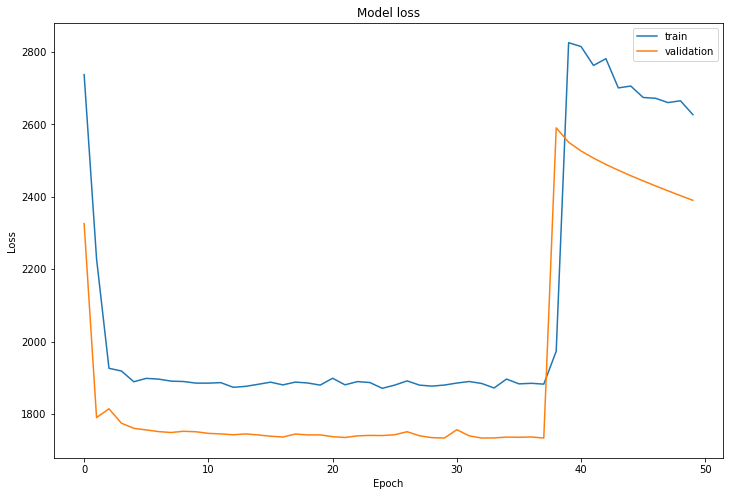

In [12]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')